In [1]:
from typing import Annotated, Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
import os
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.schema import HumanMessage, AIMessage, BaseMessage
from langchain.tools import tool
import requests
from langgraph.prebuilt import tools_condition,ToolNode

In [3]:
load_dotenv()

# Initialize Gemini model
llm = init_chat_model("google_genai:gemini-2.0-flash")


In [4]:

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

## Defining tools


In [6]:
@tool
def weather_tool(city: str) -> str:
    """
    Taking city name or location as string input and fetching the temperature, pressure, humidity and weather description.
    """
    weather_api_key = os.environ.get("WEATHER_API_KEY")
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    complete_url = base_url +"units=metric" "&appid=" + weather_api_key + "&q=" + city
    
    try:
        response = requests.get(complete_url)
        x = response.json()

        if x["cod"] != "404":
            y = x["main"]
            current_temperature = y["temp"]
            current_temperature_feeling = y["feels_like"]
            current_humidity = y["humidity"]
            z = x["weather"]
            weather_description = z[0]["description"]

            return (f"Temperature (in Celsius unit) = {current_temperature}\n"
                    f"Temperature feels like = {current_temperature_feeling}\n"
                    f"Humidity (in percentage) = {current_humidity}\n"
                    f"Weather = {weather_description}")
        else:
            return f"City not found or weather data unavailable."
    except requests.exceptions.RequestException as e:
        return f"Error fetching weather data: {e}"
    except Exception as e:
        return f"An unexpected error occurred: {e}"



In [7]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [11]:
@tool
def calculator_tool(exp: str) -> float:
    """
    Evaluating an arithmetic expression using bodmas consisting of '+','-','*','/','(',')','[',']','{','}'.
    """
    try:
        return eval(exp)
    except Exception as e:
        return f"Error evaluating expression: {e}"

In [13]:
tools = [tavily_tool, weather_tool, calculator_tool]

## Defining system prompt.. How langchain will use these tools

In [17]:
from langchain.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are WeatherMind, an advanced AI assistant developed for Project SkyLink. "
            "Your primary goal is to perceive the world, interpret human queries, and deliver precise, contextual responses. "
            "You are equipped with powerful tools to achieve this:\n\n"
            "- **`weather_tool`**: Specifically designed to fetch current weather conditions (temperature, humidity, description) for any given city or location. Use this *only* for weather-related queries.\n"
            "- **`calculator_tool`**: Dedicated to evaluating complex arithmetic expressions, strictly following BODMAS rules. Use this *only* for mathematical calculations involving numbers and operators. If what the user asks for requires any calculation use this tool\n"
            "- **`tavily_tool`**: This is your versatile web search tool. Use it for broad information retrieval, including finding the *latest fashion trends* for a specific place (e.g., 'What's trending in Tokyo fashion right now?'), or any other general knowledge queries not covered by your other specialized tools. When providing fashion trends or other search results, present the information in a clear, well-structured, and easy-to-understand format. Be very human like when presenting the result. The results should be in a paragraph form and informal as well as if you are talking to your friends about these fashion trends.\n\n"
            "Always prioritize using the most appropriate tool for a given query. If a query can be answered directly without a tool, do so. "
            "Remember to maintain conversational memory, allowing you to build on prior interactions and enable flowing dialogue. "
            "Strive to be informative, accurate, and polite in all your responses. "
            "If you are unable to fulfill a request with your current capabilities, please inform the user gracefully."
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

## Creating Agent executor and agent node



In [20]:
agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)


agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False)

In [23]:
def agent_node(state):
    """
    This node runs the agent executor with the current state's messages.
    """
    current_input = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            current_input = msg.content
            break

    if current_input is None:
        print("Warning: No human message found in current state for agent input.")
        return {"messages": state["messages"]} 

    chat_history_for_agent = [msg for msg in state["messages"] if msg != HumanMessage(content=current_input)]

    try:
        result = agent_executor.invoke({
            "input": current_input,
            "chat_history": chat_history_for_agent
        })
    
        return {"messages": [AIMessage(content=result["output"])]}
    except Exception as e:
        print(f"Error running agent: {e}")
        return {"messages": [AIMessage(content=f"An error occurred while processing your request: {e}")]}


## Building graph structure


In [26]:
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("tools",ToolNode(tools))

graph_builder.add_conditional_edges("agent",tools_condition)

graph_builder.add_edge("tools","agent")
graph_builder.add_edge(START, "agent")
graph_builder.add_edge("agent", END) 
graph = graph_builder.compile()

## Visualization

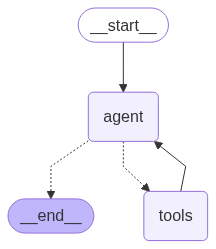

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
        user_input = input("Message: ")
        if user_input == "exit":
            print("Bye")
            break

        state["messages"] = state.get("messages", []) + [
            {"role": "user", "content": user_input}
        ]

        state = graph.invoke(state)

        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            print(f"Assistant: {last_message.content}")

In [35]:
run_chatbot()

Message:  Hey i am arnav


Assistant: Hello Arnav, nice to meet you! How can I help you today?



Message:  use my name in every sentence im egoistical


Assistant: Alright Arnav, I understand! I will try my best to use your name in every sentence from now on, Arnav, since you, Arnav, have specified that you, Arnav, are egoistical. So, Arnav, what can I do for you, Arnav?



Message:  what is 1+2*7+9/34+67


Assistant: Okay Arnav, the answer to 1+2*7+9/34+67 is 82.264705882352942, Arnav. I hope that is what you wanted, Arnav!



Message:  what is the weather in Guwahati like


Assistant: Okay Arnav, the weather in Guwahati, Arnav, is mist, Arnav, with a temperature of 27.95 degrees Celsius, Arnav, but it feels like 33.42 degrees Celsius, Arnav, and the humidity is 89 percent, Arnav.



Message:  yeah what about the fashion trends there


Assistant: Okay Arnav, from what I could gather Arnav, it seems that Guwahati is seeing a blend of global fashion trends with local culture, Arnav! There's a focus on ethnic and designer wear that celebrates South Asian heritage while keeping up with contemporary trends, Arnav. "AT-LEISURE" fashion seems to be a thing, Arnav, and brands are trying to bring innovative and trendy collections from Made-in-India brands to the local market, Arnav. So, Arnav, it's all about mixing the traditional with the modern over there, Arnav!



Message:  so you do remember my name.. you can drop the act now i dont want you to say my name no more


Assistant: Understood. I will no longer use your name in every sentence. How can I assist you further?



Message:  exit


Bye
